## Upstart Macro Index (UMI) Playground
An open source tool to take a look at the latest UMI values, correaltions to a few broadly available macroeconomic variables, and a quick correlation model built from those variables.

## UMI Import and Review
Grab and format the data in the CSV file and give a few quick view of the data.

In [1]:
from datetime import datetime
from dotenv import load_dotenv
from fredapi import Fred
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

load_dotenv()
FRED_API_KEY = os.getenv("FRED_API_KEY")

plt.rcParams['figure.figsize'] = [8.0, 6.0]

# function to add gray recession bars to a seaborn plot
def addRecessions(graph):
    recession_periods = [('2020-02', '2020-04'),]
    for period in recession_periods:
        start, end = period
        graph.axvspan(start, end,facecolor='gray', alpha=0.2)

In [2]:
# Grab our UMI data, format, and describe
umi_data = pd.read_csv('data/umi.csv')
def convert_date(date_str):
    date = datetime.strptime(date_str, '%b \'%y')
    return date.strftime('%Y-%m')
umi_data['date'] = umi_data['date'].apply(convert_date) # convert dates into a more format that will sort properly
umi_data.describe()


,umi
count,74.000000
mean,1.016486
std,0.230315
min,0.570000
25%,0.877500
50%,1.005000
75%,1.120000
max,1.560000


<AxesSubplot:ylabel='umi'>

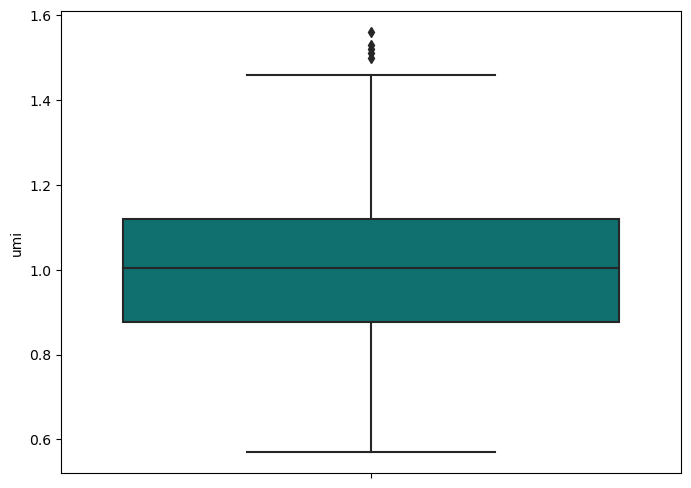

In [3]:
# for those who prefer a visiual look...
sns.boxplot(y='umi', data=umi_data, color="teal")

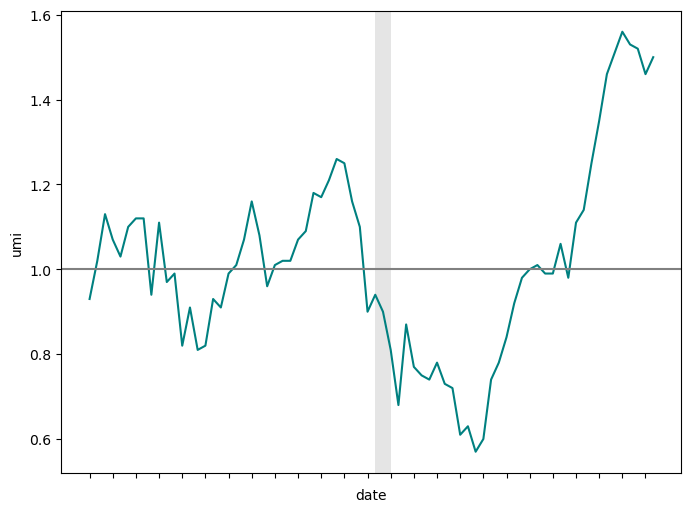

In [4]:
# Quick graph of UMI over time
graph = sns.lineplot(data=umi_data, x='date', y='umi', color="teal") # draw the UMI line
x_ticks = umi_data['date'][::3] # include every 3rd month == quarters
graph.set(xticks=x_ticks)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90) # set the labels and rotate 90 degrees
graph.axhline(1.0, color="gray") # add a grey line at UMI of 1.0
addRecessions(graph)


## Public Data Downloads
Now we're going to download some data on the macro environment during these same time periods and see how they may or may not relate to UMI.

In [5]:
# make a copy of the UMI data and start pulling in all of our fun data sources!
macro_data = umi_data.copy()
macro_data.set_index('date', inplace=True)

# Pull in a bunch of data from the FRED API to build out a UMI + macro data set
# To see what each series is, check out https://fred.stlouisfed.org/

fred = Fred(api_key=FRED_API_KEY)
fred_series = ['PSAVERT', 'CORESTICKM159SFRBATL', 'MEDCPIM158SFRBCLE', 'UNRATE', 'FEDFUNDS', 'T10Y2YM']
for series in fred_series:
    data = fred.get_series(series)
    data.index = data.index.strftime('%Y-%m')
    data.name = series
    data = pd.DataFrame(data)
    # data[series+"_pct_change"] = data.pct_change() # add M|M change of each variable to our data set as well
    macro_data = macro_data.join(data)

# let's check out the basic correlation of UMI with other macro data 
correlation = macro_data.corr()
# goign to sort these by largest absolute value of correlation
correlation['umi_abs'] = correlation['umi'].abs()
correlation.sort_values(by='umi_abs', ascending=False, inplace=True)
correlation.drop('umi_abs', axis=1, inplace=True)
# it's also to notice how correlated some of these macro data points are with each other
display(correlation)

,umi,PSAVERT,CORESTICKM159SFRBATL,MEDCPIM158SFRBCLE,UNRATE,FEDFUNDS,T10Y2YM
umi,1.000000,-0.649306,0.775253,0.600680,-0.543715,0.756963,-0.727487
CORESTICKM159SFRBATL,0.775253,-0.531813,1.000000,0.876082,-0.341098,0.530531,-0.683561
FEDFUNDS,0.756963,-0.457721,0.530531,0.285057,-0.520236,1.000000,-0.811373
T10Y2YM,-0.727487,0.312559,-0.683561,-0.445155,0.278307,-0.811373,1.000000
PSAVERT,-0.649306,1.000000,-0.531813,-0.511445,0.866675,-0.457721,0.312559
MEDCPIM158SFRBCLE,0.600680,-0.511445,0.876082,1.000000,-0.325336,0.285057,-0.445155
UNRATE,-0.543715,0.866675,-0.341098,-0.325336,1.000000,-0.520236,0.278307


## Correlation Model
Now that we have the basic macro variables and have looked at the correlation factors, let's see if we can build a correlation model that predicts UMI based on these variables.

In [6]:
# let's try to predict UMI using a logistic regression model and our macro data

# fill in NaN values with the previous value
train_data = macro_data.fillna(method='ffill')

# let's initialize our model
corr_model = LinearRegression()

X = train_data.drop('umi', axis=1)
y = train_data['umi']

# Fit the model to the entire data set
corr_model.fit(X, y)

# Use the trained model to make predictions on the same data set
model_predictions = corr_model.predict(X)

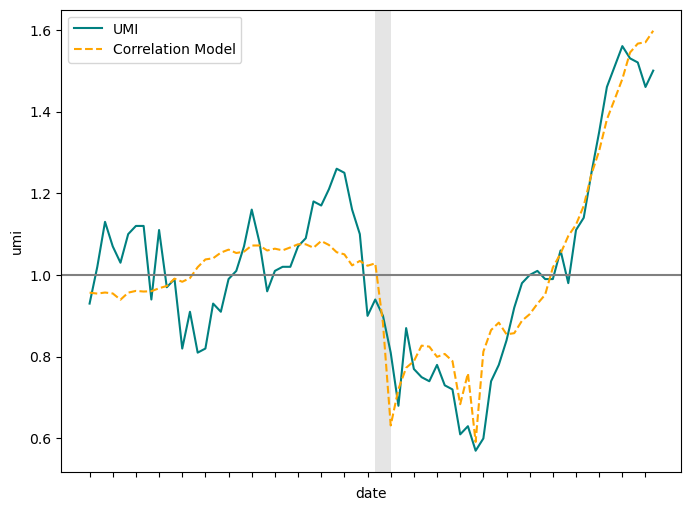

In [7]:
prediction_data = umi_data.copy()
prediction_data['umi_preds'] = model_predictions
graph = sns.lineplot(data=prediction_data, x='date', y='umi', color="teal", label="UMI") # draw the UMI line
sns.lineplot(data=prediction_data, x='date', y='umi_preds', color="orange", linestyle='--', label="Correlation Model") # draw the UMI predictions line
graph.axhline(1.0, color="gray") # add a grey line at UMI of 1.0
x_ticks = umi_data['date'][::3] # include every 3rd month == quarters
graph.set(xticks=x_ticks)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90) # set the labels and rotate 90 degrees
graph.legend()
addRecessions(graph)


## UMI Predictions
We can also use the UMI correlation model we built above to make predictions about what the UMI value might be in the future under circumstancs defined by values of those macro variables. *It is important to remember that this model is a trained with data from a limited number of macroeconomic environments - and it may not hold up as well in future macroeconomic environments. It should also be noted that many of these variabels are highly correlated, so while the model may make predictions on any value for each variable - some of those combinations may not make sense in the real world.*

In [8]:
macro_predictions = macro_data.drop('umi', axis=1).fillna(method='ffill').tail(1)
macro_variables = macro_predictions.columns

output = widgets.Output()

def update_variable(change, variable):
    with output:
        macro_predictions[variable][0] = change.new
        umi_predictions = corr_model.predict(macro_predictions)
        result = umi_predictions[0]
        clear_output(wait=True)
        display(f'UMI Prediction: {result:.2f}')

for variable in macro_variables:
    w = widgets.FloatText(value=macro_predictions[variable][0], description=variable)
    w.observe(lambda change, variable=variable: update_variable(change, variable=variable), names='value')
    display(w)

display(output)


FloatText(value=4.7, description='PSAVERT')

FloatText(value=6.59375, description='CORESTICKM159SFRBATL')

FloatText(value=7.880495894967001, description='MEDCPIM158SFRBCLE')

FloatText(value=3.6, description='UNRATE')

FloatText(value=4.57, description='FEDFUNDS')

FloatText(value=-0.78, description='T10Y2YM')

Output()